In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import cProfile
import pstats
from inpainting import InpaintNNF

## A. Time Complexity Analysis (Theoretical)

The time complexity of the PatchMatch algorithm per iteration is dominated by the patch distance calculations during the propagation and random search steps.

- **Per-iteration**: `O(H * W * patch_w²)` where `H` is height, `W` is width, and `patch_w` is the patch width. For each of the `H * W` pixels, we perform a patch comparison which takes `O(patch_w²)`.
- **Total**: `O(iterations * H * W * patch_w²)` where `iterations` is the number of PatchMatch iterations (propagation + search).

The multi-scale pyramid adds a factor, but since each level is smaller, the total complexity remains dominated by the largest level. The total work across all pyramid levels is roughly `1 + 1/4 + 1/16 + ...` which converges to `4/3`. So the pyramid adds a constant factor, not a change in complexity class.

## B. Space Complexity Analysis (Theoretical)

The memory usage is primarily for storing the images, masks, and the Nearest-Neighbor Field (NNF).

- **Image Storage**: `H * W * 3` (for a 3-channel image)
- **NNF Storage**: `H * W * 2` (to store the x, y offset for each patch)
- **Distance Storage**: `H * W` (to store the distance for each patch)
- **Pyramid Overhead**: The pyramid of images and masks adds approximately `1/3` more memory (`1 + 1/4 + 1/16 + ... ≈ 1.33`).

The total space complexity is therefore `O(H * W)`.

## C. Scalability Tests (Empirical)

We will now measure the actual runtime of the algorithm on images of increasing size to verify the theoretical time complexity.

In [2]:
image_sizes = [200, 400, 600, 800]
scalability_results = []

for size in image_sizes:
    print(f"Testing image size: {size}x{size}...")
    # Create a dummy image and a mask with a hole in the center
    dummy_image = np.random.randint(0, 256, (size, size, 3), dtype=np.uint8)
    dummy_mask = np.zeros((size, size), dtype=np.uint8)
    center = size // 2
    hole_size = size // 4
    cv2.circle(dummy_mask, (center, center), hole_size, 255, -1)

    start_time = time.time()
    inpaint_nnf = InpaintNNF(dummy_image, dummy_mask, patch_w=7, max_pm_iters=3)
    _ = inpaint_nnf.inpaint()
    end_time = time.time()

    processing_time = end_time - start_time
    scalability_results.append({
        "pixels": size * size,
        "time": processing_time
    })
    print(f"  Done in {processing_time:.2f}s")

Testing image size: 200x200...
Level 5 done in 0.1300337314605713 seconds.
Level 4 done in 0.9548146724700928 seconds.
Level 3 done in 4.216803550720215 seconds.
Level 2 done in 18.498859405517578 seconds.
Level 1 done in 56.51397728919983 seconds.
  Done in 81.05s
Testing image size: 400x400...
Level 6 done in 0.0723714828491211 seconds.
Level 5 done in 0.6464943885803223 seconds.
Level 4 done in 5.069608449935913 seconds.
Level 3 done in 25.239146947860718 seconds.
Level 2 done in 107.91896891593933 seconds.
Level 1 done in 1138.05446267128 seconds.
  Done in 1278.65s
Testing image size: 600x600...
Level 7 done in 0.04223322868347168 seconds.
Level 6 done in 0.31337785720825195 seconds.
Level 5 done in 3.026588201522827 seconds.
Level 4 done in 18.043533325195312 seconds.
Level 3 done in 83.86610007286072 seconds.
Level 2 done in 358.648149728775 seconds.
Level 1 done in 3289.206429719925 seconds.
  Done in 3757.16s
Testing image size: 800x800...
Level 7 done in 0.08809566497802734 s

### Plot Scalability Results

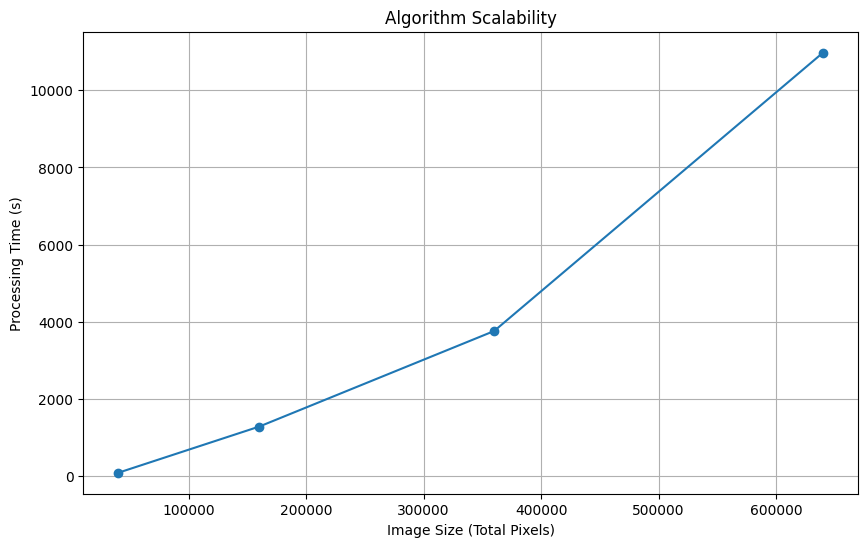

In [3]:
pixels = [r['pixels'] for r in scalability_results]
times = [r['time'] for r in scalability_results]

plt.figure(figsize=(10, 6))
plt.plot(pixels, times, marker='o')
plt.title('Algorithm Scalability')
plt.xlabel('Image Size (Total Pixels)')
plt.ylabel('Processing Time (s)')
plt.grid(True)
plt.show()

## D. Code Profiling

We use Python's `cProfile` to identify which functions are the most time-consuming (bottlenecks).

In [ ]:
# Load a real image for more realistic profiling
src_path = '../images/football_sky.jpg'
mask_path = '../images/football_sky_mask.jpg'
src = cv2.imread(src_path)
mask = cv2.imread(mask_path, 0)

# Create an instance of the inpainter
profiler_inpaint = InpaintNNF(src, mask, patch_w=7, max_pm_iters=3)

# Profile the inpaint() method
profiler = cProfile.Profile()
profiler.enable()

profiler_inpaint.inpaint()

profiler.disable()

# Print the stats
stats = pstats.Stats(profiler).sort_stats('cumulative')
print("--- Top 20 Most Time-Consuming Functions ---")
stats.print_stats(20)

Level 6 done in 0.23364686965942383 seconds.
Level 5 done in 2.1771018505096436 seconds.
Level 5 done in 2.1771018505096436 seconds.
Level 4 done in 13.102859497070312 seconds.
Level 4 done in 13.102859497070312 seconds.
Level 3 done in 56.81845450401306 seconds.
Level 3 done in 56.81845450401306 seconds.
Level 2 done in 251.82803225517273 seconds.
Level 2 done in 251.82803225517273 seconds.
Level 1 done in 1291.7930307388306 seconds.
--- Top 20 Most Time-Consuming Functions ---
         500545845 function calls in 1615.955 seconds

   Ordered by: cumulative time
   List reduced from 80 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000 1615.955  807.977 /home/eswarkumar/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3543(run_code)
        2    0.000    0.000 1615.955  807.977 {built-in method builtins.exec}
        1    0.001    0.001 1615.955 1615.955 /home/eswarkumar/Desktop/PatchMa